In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,precision_score, recall_score, accuracy_score, f1_score

import random
from matplotlib import pyplot as plt
import pickle
import xgboost as xgb

from collections import namedtuple, OrderedDict
import eli5
from eli5.sklearn import PermutationImportance
import shap
from IPython.display import display, HTML

%run myxgboost_model.ipynb
%matplotlib inline

/home/dinab/opt/anaconda3/envs/kaggle2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/dinab/opt/anaconda3/envs/kaggle2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Possible set intersection at position 3


### Feature importance:

In [2]:
# Make the data using two features::
# Is currently a student: 
# 0- no, 1-yes
# income average grouped based on Quartiles

np.random.seed(42)
is_student = np.array([1] * 1000 + [0] * 1200)
incomes = np.round(np.random.randint(low=30000, high=120000, size=2200) / 1000) * 1000  # random distribution of incomes
# bin the incomes according to quartiles:
incomes_qnts = pd.qcut(incomes, 4, labels=False)
# shuffle data
np.random.shuffle(is_student)
np.random.shuffle(incomes_qnts)
features = ['student', 'income_group']
data = np.concatenate([is_student.reshape(-1, 1), incomes_qnts.reshape(-1, 1)], axis=1)
pddata = pd.DataFrame(data, columns=features)

labels = [1 if s == 1 and a == 1 else 0 for s, a in data]

#### Weight metric:

In [3]:
# Train a model:
path_result=None
X_train, X_test, y_train, y_test = train_test_split(pddata, labels, test_size=0.2, random_state=42)
xgb_model1 = XgboostModel(X_train, y_train, X_test, y_test, optimized_params=True)
xgb_model1.train(path_result, do_hps=False, do_split=False, do_save=False, do_print=True, seed=42)


Training...
Preforming prediction of the test data
Precision: 1.0, Accuaracy: 1.0, Recall: 1.0, F1_score: 1.0


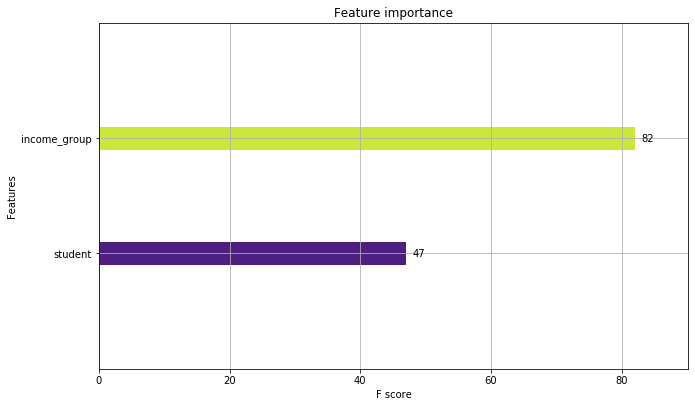

In [4]:
fig, ax = plt.subplots(1,1,figsize=[10,6])
feature_importances = xgb.plot_importance(xgb_model1.xg_class, ax=ax,  color=[(0.3,0.12,0.5), (0.8,0.9,0.23)])
plt.rc('font', size=18)
plt.tight_layout()


#### How will different encoding change the results: 

Now, the only difference we introduce to the data is : # grownups - 0, children - 1, old people - 2
So the desired category in age feature is 0

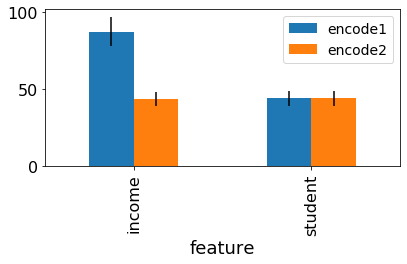

In [5]:
path_results = None
#### case 1: label=1
labels = [1 if s == 1 and a == 1 else 0 for s, a in data]
X_train, X_test, y_train, y_test = train_test_split(pddata, labels, test_size=0.2, random_state=42)
student_imp1 = []
income_imp1 = []

n = 100
np.random.seed(XgboostModel.DEFAULT_SEED)
model_seed = np.random.randint(low=0, high=200, size=n)

for i in range(n):
    xgb_model = XgboostModel(X_train, y_train, X_test, y_test, optimized_params=True)

    xgb_model.train(path_result, do_hps=False, do_split=False, do_save=False, do_print=False, seed=model_seed[i])
    feature_importances = xgb_model.xg_class.get_booster().get_score(importance_type='weight')
    student_imp1.append(feature_importances['student'])
    income_imp1.append(feature_importances['income_group'])


#### case 2: label=0
labels = [s == 1 and a == 0 for s, a in data]

X_train, X_test, y_train, y_test = train_test_split(pddata, labels, test_size=0.2, random_state=42)
student_imp2 = []
income_imp2 = []

for i in range(n):
    xgb_model = XgboostModel(X_train, y_train, X_test, y_test, optimized_params=True)

    xgb_model.train(path_results, do_hps=False, do_split=False, do_save=False, do_print=False, seed=model_seed[i])
    feature_importances = xgb_model.xg_class.get_booster().get_score(importance_type='weight')
    student_imp2.append(feature_importances['student'])
    income_imp2.append(feature_importances['income_group'])

df = pd.DataFrame([['student', 'encode1', np.mean(student_imp1), np.std(student_imp1)],
                   ['student', 'encode2', np.mean(student_imp2), np.std(student_imp2)],
                   ['income', 'encode1', np.mean(income_imp1), np.std(income_imp1)],
                   ['income', 'encode2', np.mean(income_imp2), np.std(income_imp2)]],
                  columns=['feature', 'encoding', 'mean_importance', 'std_importance'])

ax = df.pivot(index='feature', columns='encoding', values='mean_importance').plot(kind='bar', yerr=df.pivot(index='feature',
                                                            columns='encoding', values='std_importance').values, fontsize=16)
ax.legend(fontsize=14)
plt.tight_layout()

#### Other metrics:

In [6]:
# load model: 
criterions = ['weight', 'gain', 'total_gain', 'cover', 'total_cover']
imps = []
student_imps = []
income_group_imps = []
for c in criterions:
    feature_importances = xgb_model1.xg_class.get_booster().get_score(importance_type=c)
    imps.append(feature_importances)
    student_imps.append(feature_importances['student'])
    income_group_imps.append(feature_importances['income_group'])

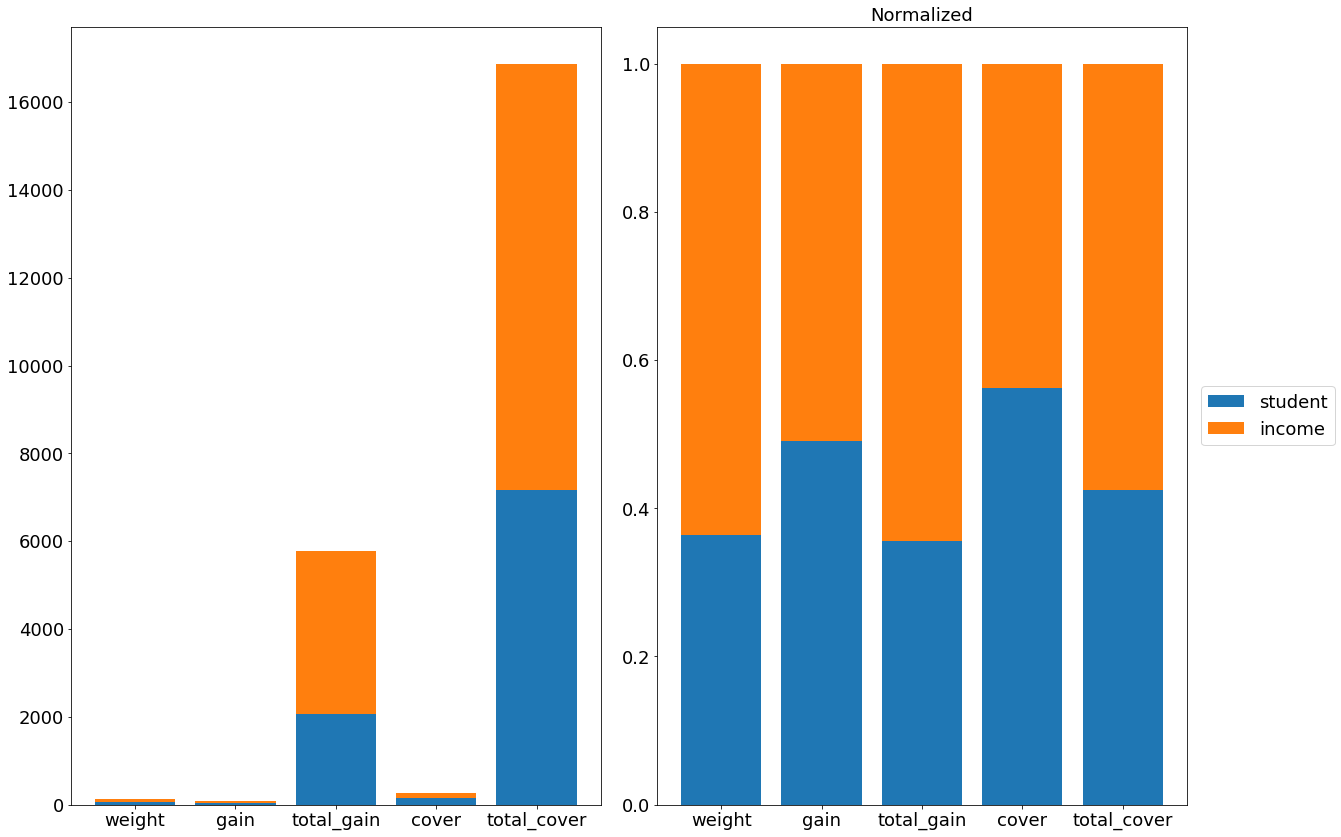

In [7]:
npstu = np.array(student_imps)
npin = np.array(income_group_imps)
snum = npstu + npin

# normalization
norm_npstu = npstu/snum
norm_npin = npin/snum

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,12))
#fig.suptitle('xgboost feature importance using different metrics', fontsize=20)
ax1.bar(criterions, npstu, label='student')
ax1.bar(criterions, npin ,bottom=npstu,label='income')


ax2.bar(criterions, norm_npstu, label='student')
ax2.bar(criterions, norm_npin ,bottom=norm_npstu,label='income')
ax2.legend(bbox_to_anchor=(1.01,0.5), loc='center left', prop={'size': 18})
ax2.set_title('Normalized', fontsize=18)

plt.rc('font', size=19) 
plt.tight_layout()

### Using permutations:

In [8]:
# Train another model:
train = pd.read_csv("../input/Titanic/train_processed_nonohe.csv")
mytest = pd.read_csv("../input/Titanic/mytest_processed_nonohe.csv")

# Drop passenger id:
mytest.drop(labels=["PassengerId"], axis=1, inplace=True)
train.drop(labels=["PassengerId"], axis=1, inplace=True)
train["Survived"] = train["Survived"].astype(int)
mytest["Survived"] = mytest["Survived"].astype(int)
y_train = train[["Survived"]]
X_train = train.drop(labels=["Survived"], axis=1)
y_test = mytest[["Survived"]]
X_test = mytest.drop(labels=["Survived"], axis=1)

# Normalization of data
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
columns_to_normalize = ['Parch', 'Age', 'Fare', 'SibSp']
X_train_cols_copy = X_train[columns_to_normalize].copy()
X_test_cols_copy = X_test_norm[columns_to_normalize].copy()

mean = X_train[columns_to_normalize].mean()
std = X_train[columns_to_normalize].std()
X_train_norm[columns_to_normalize] = (X_train_cols_copy - mean) / std
X_test_norm[columns_to_normalize] = (X_test_cols_copy - mean) / std

X_train = X_train_norm
X_test = X_test_norm

path_result=None
xgb_model2 = XgboostModel(X_train, y_train, X_test, y_test, optimized_params=True)
xgb_model2.train(path_result, do_hps=False, do_split=False, do_save=False, do_print=True, seed=123)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Training...
Preforming prediction of the test data
Precision: 0.8153846153846154, Accuaracy: 0.8659217877094972, Recall: 0.8153846153846154, F1_score: 0.8153846153846154


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [9]:
perm_test = []
perm_train = []
mean_perm_test = []
mean_perm_train = []
std_perm_test = []
std_perm_train = []
np.random.seed(42)
model_seed = np.random.randint(low=0, high=200, size=n)
for i in range(5):
    perm_test.append(PermutationImportance(xgb_model2.xg_class, random_state=model_seed[i]).fit(X_test, y_test)) 
    perm_train.append(PermutationImportance(xgb_model2.xg_class, random_state=model_seed[i]).fit(X_train, y_train)) 

    mean_perm_test.append(perm_test[i].feature_importances_)
    mean_perm_train.append(perm_train[i].feature_importances_)
    std_perm_test.append(perm_test[i].feature_importances_std_)
    std_perm_train.append(perm_train[i].feature_importances_std_)

df_mtest = pd.DataFrame(mean_perm_test).T
df_stest = pd.DataFrame(std_perm_test).T
df_mtest.index = X_test.columns
df_stest.index = X_test.columns
df_mtrain = pd.DataFrame(mean_perm_train).T
df_strain = pd.DataFrame(std_perm_train).T
df_mtrain.index = X_train.columns
df_strain.index = X_train.columns

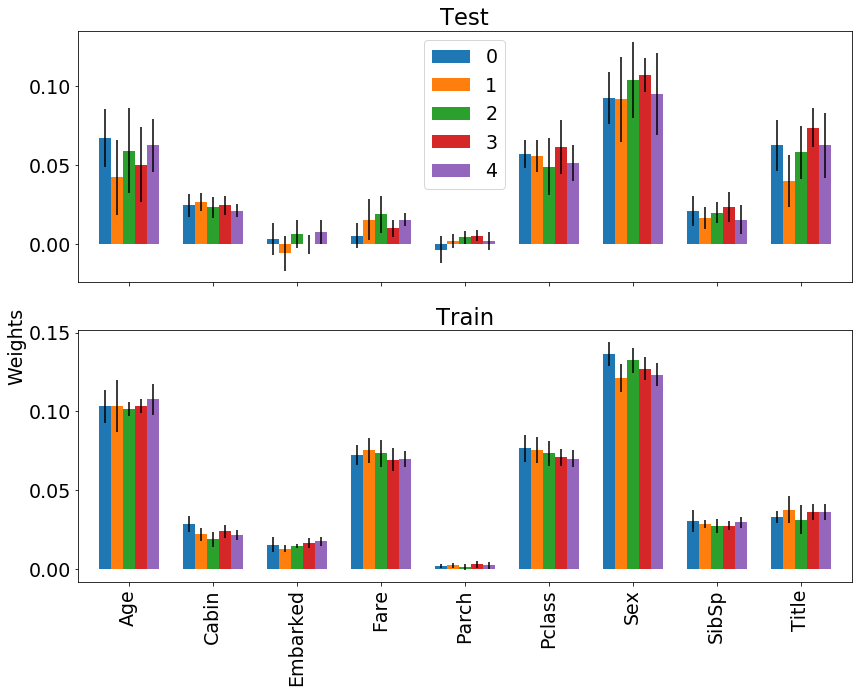

In [10]:
fig, [ax1, ax2] = plt.subplots(2,1,figsize=[12,10])
df_mtest.plot.bar(yerr=df_stest, ax=ax1,  width=0.71)
df_mtrain.plot.bar(yerr=df_strain, ax=ax2, width=0.71, legend=False)
ax1.tick_params(labelbottom=False)  
fig.text(0.01, 0.5, 'Weights', ha='center', va='center', rotation='vertical')
ax1.set_title('Test')
ax2.set_title('Train')
plt.rc('font', size=19) 
plt.tight_layout()

### Using SHAP:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


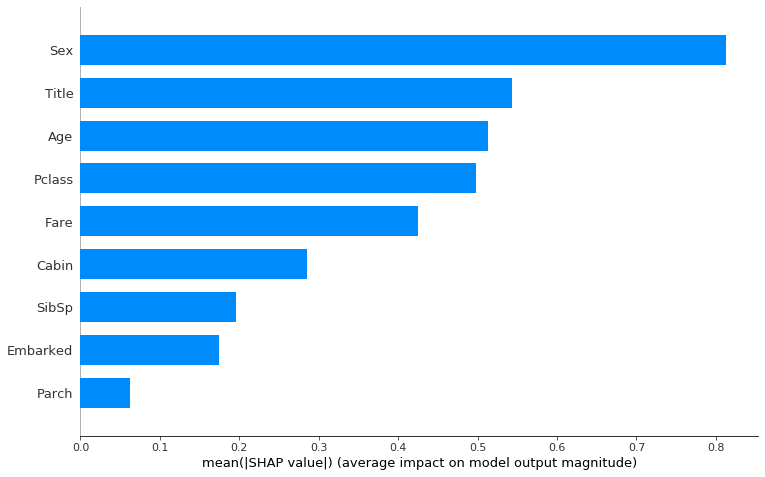

In [11]:
explainer = shap.TreeExplainer(xgb_model2.xg_class, feature_perturbation = "tree_path_dependent" )
shap_values = explainer.shap_values(X_test)
plt.subplot(111)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(11,7), show=False)
plt.tight_layout()

## Compare:

In [12]:
feature_importances = xgb_model2.xg_class.get_booster().get_score(importance_type='total_gain')
perm_test = PermutationImportance(xgb_model2.xg_class, random_state=42).fit(X_test, y_test)
perm_train = PermutationImportance(xgb_model2.xg_class, random_state=42).fit(X_train, y_train)
perm_test_im = perm_test.feature_importances_
perm_train_im = perm_train.feature_importances_

In [13]:
feature_importances

{'Cabin': 154.4772375712901,
 'Age': 811.0124404040992,
 'SibSp': 173.06274033992997,
 'Embarked': 123.94912439569,
 'Parch': 69.34053556741003,
 'Title': 504.42108842600004,
 'Pclass': 309.83090992112994,
 'Sex': 651.1277701078999,
 'Fare': 749.7023759198405}

In [14]:
feature_importances = OrderedDict([(el, feature_importances[el]) for el in X_train.columns])

fi_order = len(X_train.columns) - np.argsort(np.argsort(list(feature_importances.values())))
ptest_order = len(X_train.columns) - np.argsort(np.argsort(perm_test_im))
ptrain_order = len(X_train.columns) - np.argsort(np.argsort(perm_train_im))
df_compared = pd.DataFrame([fi_order, ptest_order, ptrain_order]).T 

df_compared.index = X_train.columns
df_compared.columns = ['feature_importances', 'permutations_test', 'permutations_train']

In [15]:
display(df_compared)


,feature_importances,permutations_test,permutations_train
Age,1,4,2
Cabin,7,5,7
Embarked,8,9,8
Fare,2,7,3
Parch,9,8,9
Pclass,5,3,4
Sex,3,1,1
SibSp,6,6,6
Title,4,2,5


In [16]:
# top 3 features:

top3_fi = [x for _, x in sorted(zip(fi_order[fi_order<4],X_train.columns[fi_order<4]), key=lambda pair: pair[0])]
top3_ptest = [x for _, x in sorted(zip(ptest_order[ptest_order<4],X_train.columns[ptest_order<4]), key=lambda pair: pair[0])]
top3_ptrain = [x for _, x in sorted(zip(ptrain_order[ptrain_order<4],X_train.columns[ptrain_order<4]), key=lambda pair: pair[0])]

df_top3= pd.DataFrame([top3_fi, top3_ptest, top3_ptrain]).T 
df_top3.columns = ['feature_importances', 'permutations_test', 'permutations_train']
df_top3.index = [1,2,3]

In [17]:
df_top3

,feature_importances,permutations_test,permutations_train
1,Age,Sex,Sex
2,Fare,Title,Age
3,Sex,Pclass,Fare
